In [1]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np

## Creating training and test data

In [2]:
mean = 0.1377
std = 0.3125
transform_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


train_data = datasets.MNIST("data/", train = True, transform = transform_norm, download = True)
test_data = datasets.MNIST("data/", train = False, transform = transform_norm)

# the data could be flattend here, but I will include the flatten function in my DNN Mode

print(torch.std(train_data[0][0]))

train_dataloader = DataLoader(train_data, 32, shuffle = True)
test_dataloader = DataLoader(test_data, 32, shuffle = False)


tensor(1.0002)


The data needs to be preprocessed, that means flattend and turned into tensors. Normalization improves the performance of the data, so it should be used in the transformation.
The data needs to be flattend, because we use linear layers that use 2 1D coloumb vectors for the weights and input values and a bias for computation. That means linear layers wont work for matrices such as images, so they have to be turned into a 1D Array. Convolutional layers would work for matrices, but the computation is different.
The data needs to be turned into tensors so that we can use it for further computation and all the functionality of Pytorch


## Visualizing Data

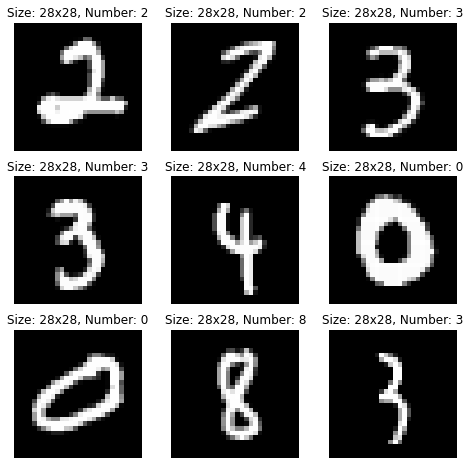

In [3]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f"Size: {(img.shape)[1]}x{(img.shape)[2]}, Number: {label}")
    plt.axis("off")
    plt.imshow(img.squeeze(dim=0), cmap="gray")
plt.show()

## Creating the NN Model

In [4]:
class Digits(nn.Module):
    def __init__(self):
        super().__init__()
        self.nn = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 224),
            nn.ReLU(),
            nn.Linear(224, 112),
            nn.ReLU(),
            nn.Linear(112, 28),
            nn.ReLU(),
            nn.Linear(28, 10),
            nn.Softmax(dim = 1)
        )

    def forward(self, x):
        
        return self.nn(x)
        



In [5]:
net = Digits()
print((torch.argmax(net(train_data[0][0]), dim = 1)))
data = list(train_dataloader)[0]
img, label = data
print(label)

tensor([1])
tensor([5, 7, 3, 9, 3, 6, 1, 1, 9, 3, 2, 9, 7, 4, 4, 7, 0, 0, 1, 5, 1, 7, 1, 7,
        0, 6, 4, 7, 0, 6, 2, 1])


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Seting up the training 

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.1)

In [8]:
epoch = 5
train_history = []
test_history = []
for e in range(epoch):
    net.train()
    train_loss = 0
    train_acc = 0
    for i, data in enumerate(train_dataloader):
        img, label = data
        

        output = net(img)
        loss = loss_fn(output, label)
        pred_y = torch.argmax(output, dim = 1)

        train_loss += loss
        correct = torch.eq(label, pred_y).sum().item()
        acc = (correct / len(pred_y)) * 100 
        train_acc += acc

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    print(f"Epoch{e}: train accuaracy = {train_acc:.2F}%, train loss: {train_loss:.5f}")

    net.eval()
    test_loss = 0
    test_acc = 0
    with torch.inference_mode():
        for i, data in enumerate(test_dataloader):
            img, label = data
            output = net(img)
            pred_output = torch.argmax(output, dim = 1)
            loss = loss_fn(output, label)
            test_loss += loss.item()
            correct = torch.eq(label, pred_output).sum().item()
            acc = (correct / len(pred_output)) * 100 
            test_acc += acc
        
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
    print(f"Epoch{e}: test accuaracy = {test_acc:.2F}%, test loss: {test_loss:.5f}")
    

Epoch0: train accuaracy = 76.55%, train loss: 1.71041
Epoch0: test accuaracy = 92.64%, test loss: 1.53916
Epoch1: train accuaracy = 93.71%, train loss: 1.52723
Epoch1: test accuaracy = 95.13%, test loss: 1.51105
Epoch2: train accuaracy = 95.47%, train loss: 1.50844
Epoch2: test accuaracy = 96.11%, test loss: 1.50140
Epoch3: train accuaracy = 96.38%, train loss: 1.49854
Epoch3: test accuaracy = 96.32%, test loss: 1.49887
Epoch4: train accuaracy = 96.94%, train loss: 1.49289
Epoch4: test accuaracy = 96.73%, test loss: 1.49418


## This code is from the website:
https://www.learnpytorch.io/03_pytorch_computer_vision/#9-make-and-evaluate-random-predictions-with-best-model
Chapter 3.9

In [15]:
import random
classes = train_data.classes 
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

In [16]:
pred_probs = []
net.eval()
with torch.inference_mode():
    for sample in test_samples:
           
        sample = torch.unsqueeze(sample, dim=0)

        pred_logit = net(sample)

            # Get prediction probability (logit -> prediction probability)
        pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

        pred_probs.append(pred_prob)
            
    # Stack the pred_probs to turn list into a tensor
pred_probs = torch.stack(pred_probs)

In [17]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([6, 5, 0, 1, 2, 0, 2, 1, 2])

In [18]:
test_labels, pred_classes

([6, 5, 0, 1, 2, 0, 2, 1, 2], tensor([6, 5, 0, 1, 2, 0, 2, 1, 2]))

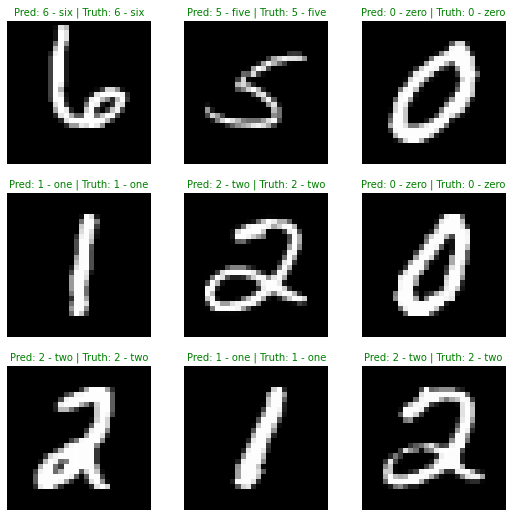

In [19]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")
  
  pred_label = classes[pred_classes[i]]

  # Get the truth label 
  truth_label = classes[test_labels[i]] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") 
  else:
      plt.title(title_text, fontsize=10, c="r")
  plt.axis(False);

In [14]:
torch.save(net,"digit_model.pt")